In [2]:
import numpy as np
import open3d as o3d
import copy
import csv
from matplotlib import pyplot as plt
from open3d import visualization
import file_path
import ICP_func

In [3]:
#FOR TUM DATASET
x = [] #dvs pixel x in mm
y = [] #dvs pixel y in mm
depth = [] #depth from depth sensor
time_stamp = [] 
x_pixel = [] #dvs pixel x in mm
y_pixel = [] #dvs pixel y 


#events.tsv: A TSV file where each row corresponds to one event.
# Provided data is: PrimeSense image coordinates (x,y), PrimeSense depth measurement,
# EDVS image coordinates (x,y), Timestamp (in microsenconds), EDVS parity flag

base_directory = r"/home/bru/Dev/DATA/scn2_take01/take01/"
filename = "events.csv" 
full_path = file_path.file_path(base_directory, filename)

with open(full_path, encoding="Latin-1") as csvfile:  #change this according to your file 
    reader = list(csv.reader(csvfile, delimiter=","))

num_events = len(reader)
num_events_batch = 5000

for i in range(0,num_events):
    depth.append((reader[i][2]))
    x.append(((int(reader[i][3])/128)-0.5)*1000) # convert x_pixels to x in millimeters (according to camera intrinsics of DAVIS128) K = [128, 0, 64; 0, 128, 64; 0, 0, 1]
    y.append(((int(reader[i][4])/128)-0.5)*1000) # convert y_pixels to y in millimeters
    x_pixel.append(int(reader[i][3])) 
    y_pixel.append(int(reader[i][4]))
    time_stamp.append((reader[i][5]))
depth = np.array(depth).astype(np.float64)
Max_depth = depth.max()
Min_depth = depth.min()
x = np.array(x)
x = x-x.min()
y = np.array(y)
y = y-y.min()

In [4]:
iEv = 0 #num event
iBatch = 0 #num batch
data_size = (num_events_batch ,3) 
num_arr = 0
while True:
    # Check if we have processed all events
    if (iEv + num_events_batch > num_events):
        break
        
    # Select subset of events or data
    iEv += num_events_batch
    iBatch += 1
    
    depth_batch = np.array(depth[iEv+0:iEv+num_events_batch]).astype(np.float64)
    x_batch = np.array(x[iEv+0:iEv+num_events_batch]).astype(np.float64)
    y_batch = np.array(y[iEv+0:iEv+num_events_batch]).astype(np.float64)
    #batches = (np.c_[x_batch,y_batch, depth_batch]).astype(np.float64)
    #print(batches)
    x_max = int(x_batch.max())
    y_max = int(y_batch.max())
    if y_max < x_max:
        img = np.zeros((int(x_batch.max()+1),int(x_batch.max()+1)))
        count = np.zeros((int(x_batch.max()+1),int(x_batch.max()+1))) 
    else:
        img = np.zeros((int(y_batch.max()+1),int(y_batch.max()+1)))
        count = np.zeros((int(y_batch.max()+1),int(y_batch.max()+1)))
        
        for i in range(num_events_batch):
        # Need to convert the polarity bit from {0,1} to {-1,+1} and accumulate
            img[int(y_batch[i]),int(x_batch[i])] += (int(depth_batch[i]))
            count[int(y_batch[i]),int(x_batch[i])] += 1

    # Compute per-pixel average if count at the pixel is >1
        count[count < 1] = 1  # to avoid division by zero
        img = img / count*2

In [5]:
x_pos = []
y_pos = []
z_pos = []
x_rot = []
y_rot = []
z_rot = []
T_rest = np.identity(4)
T_new = []
T_orj = []

num_batch_apart = 1 #skip this much point cloud (When point clouds are too close to each other, there is not much change)
#Can be dynamically change!!

T_skip = 10

for i in range(T_skip):
    filename_source = "point_clouds/depth_event_%08d.ply" %i
    full_path_source = file_path.file_path(base_directory, filename_source)
    source = o3d.io.read_point_cloud(full_path_source)
    
    filename_target = "point_clouds/depth_event_%08d.ply" %(i+num_batch_apart)
    full_path_target = file_path.file_path(base_directory, filename_target)
    target = o3d.io.read_point_cloud(full_path_target)
    
    max_correspondence_distance = 30   # mm, for ICP
    trans_init = np.identity(4) #for ICP to initialize transformation matrix might be changed to see how robust the algorithm is??
    
    evaluation = o3d.pipelines.registration.evaluate_registration(source, target,
                                                    max_correspondence_distance, trans_init)
          
    #POINT TO POINT ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=3000))
    
    # The class TransformationEstimationPointToPoint provides functions to compute the residuals and Jacobian matrices of the point-to-point ICP objective. 
    # The function registration_icp takes it as a parameter and runs point-to-point ICP to obtain the results.
  
    T = reg_p2p.transformation
    T_orj.append(T) # list of delta T, transformations from one scene to another
   
    T_rest = np.dot(T_rest, T)
print(T_rest)
    #T_new.append(T_rest)
    

[[ 9.99291780e-01  1.71996831e-02  3.34680471e-02 -5.02497975e+01]
 [-1.52541503e-02  9.98226517e-01 -5.75424287e-02  1.58054611e+02]
 [-3.43984037e-02  5.69911494e-02  9.97781919e-01 -2.37025013e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [6]:
x_gt = []
y_gt = []
z_gt = []
x_rot = []
y_rot = []
z_rot = []

filename = "gt.csv" 
full_path = file_path.file_path(base_directory, filename)

with open(full_path, encoding="Latin-1") as csvfile:
    reader = list(csv.reader(csvfile, delimiter=','))

num_data = len(reader)
print("number of rows in 'Ground Truth Data':",num_data)
print("number of rows in 'ICP Estimation':", iBatch)

reader = np.array(reader).astype(np.float64)

for i in range(1,num_data):
    #Set beginning to (0,0,0) position 
    reader[i][0] = (reader[i][0])-(reader[0][0]) 
    reader[i][1] = (reader[i][1])-(reader[0][1]) 
    reader[i][2] = (reader[i][2])-(reader[0][2]) 
    
    x_gt.append((reader[i][0]))  #x position
    y_gt.append((reader[i][1]))  #y position
    z_gt.append((reader[i][2]))  #z position
    
   
    z_rot.append((reader[i][3])) #z rotation 
    x_rot.append((reader[i][4])) #x rotation
    y_rot.append((reader[i][5])) #y rotation
    

x_gt = (np.array(x_gt).astype(np.float64))
y_gt = (np.array(y_gt).astype(np.float64))
z_gt = (np.array(z_gt).astype(np.float64))
    

number of rows in 'Ground Truth Data': 2299
number of rows in 'ICP Estimation': 196


In [7]:
from scipy.spatial.transform import Rotation as R
positions = (np.c_[x_gt,y_gt,z_gt]).astype(np.float64)
rotations = (np.c_[z_rot,x_rot,x_rot]).astype(np.float64)
print(len(positions))
print(len(rotations))
def euler_to_rot_matrix(rotations):
    # Convert the Euler angle to rotation matrix
    rotations = np.radians(rotations)  # Convert to radians
    r = R.from_euler('zyx', rotations)  # Assuming the rotations are in the order of ZYX
    return r.as_matrix()

def create_transformation_matrix(positions, rotations):
    # Create the transformation matrix
    rot_matrix = euler_to_rot_matrix(rotations)
    
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rot_matrix
    transformation_matrix[:3, 3] = positions
    
    return transformation_matrix

T_rest_gt = np.identity(4)
for i in range(len(positions)):
    
    transformation_matrix_c = create_transformation_matrix(positions[i], rotations[i])
    T_rest_gt = np.dot(T_rest_gt, transformation_matrix_c)
    
print(T_rest_gt)

2298
2298
[[ 9.03711342e-01 -2.07030917e-01 -3.74758602e-01 -1.20447951e+05]
 [ 1.73680690e-02  8.92319929e-01 -4.51069279e-01 -7.29580509e+04]
 [ 4.27789856e-01  4.01127590e-01  8.09995368e-01  1.82081890e+05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [8]:
source = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %0)
target = o3d.io.read_point_cloud("/home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_%08d.ply" %195)

print(o3d.geometry.PointCloud.get_max_bound(source))
print(o3d.geometry.PointCloud.get_max_bound(target))
bounding_box = o3d.geometry.AxisAlignedBoundingBox(np.array([0,0,0]), np.array([493,440,2000]))
#source = o3d.geometry.PointCloud.crop(source,bounding_box)
#target = o3d.geometry.PointCloud.crop(target,bounding_box)
print(o3d.geometry.PointCloud.get_min_bound(source))
print(o3d.geometry.PointCloud.get_min_bound(target))

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    
    source_temp.transform(transformation)
    
    #o3d.visualization.draw([source_temp, target_temp])
    o3d.visualization.draw_geometries(
        [source_temp,
         target_temp])
    
#draw_registration_result(source, target, T_rest)

#max_correspondence_distance = 30   # mm, for ICP
#evaluation = o3d.pipelines.registration.evaluate_registration(source, target,
                                                    #max_correspondence_distance, T_rest)

#print(evaluation)

[Open3D WARNING] Read PLY failed: unable to open file: /home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_00000000.ply
[Open3D WARNING] Read PLY failed: unable to open file: /home/bru/Dev/DATA/data/scn2c_take01/take01/point_clouds/depth_event_00000195.ply
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]


RPly: Unable to open file
RPly: Unable to open file


In [9]:
def backproject(points_3d, intrinsic_matrix, extrinsic_matrix):
    """
    Backproject 3D points to 2D image points.
   

    :param points_3d: Nx3 numpy array of 3D points.
    :param intrinsic_matrix: 3x3 intrinsic camera matrix K.
    :param extrinsic_matrix: 4x4 extrinsic camera matrix [R|t].
    :return: Nx2 numpy array of 2D points.
    """
    # Convert points to homogeneous coordinates
    points_from_pcd = np.asarray(points_3d.points)
    points_3d_hom = np.hstack((points_from_pcd, np.ones((points_from_pcd.shape[0], 1))))

    # Apply extrinsic matrix
    points_cam_hom = np.dot(points_3d_hom, extrinsic_matrix.T)

    # Convert from homogeneous to 3D coordinates
    points_cam = points_cam_hom[:, :3] / points_cam_hom[:, 3, np.newaxis]

    # Apply intrinsic matrix
    points_img_hom = np.dot(points_cam, intrinsic_matrix.T)

    # Convert from homogeneous to 2D coordinates
    points_img = points_img_hom[:, :2] / points_img_hom[:, 2, np.newaxis]

    return points_img

K = np.array([
    [128, 0, 64],  # fx, 0, cx
    [0, 128, 64],  # 0, fy, cy
    [0, 0, 1]      # 0, 0, 1
])

T_init = np.identity(4)

In [10]:
source = o3d.io.read_point_cloud("/home/bru/Dev/DATA/scn2_take01/take01/point_clouds/depth_event_%08d.ply" %0)
target = o3d.io.read_point_cloud("/home/bru/Dev/DATA/scn2_take01/take01/point_clouds/depth_event_%08d.ply" %195)

source_points_gt = backproject(source, K, T_rest_gt)
source_points = backproject(source, K, T_rest)

target_points = backproject(target, K, T_init)

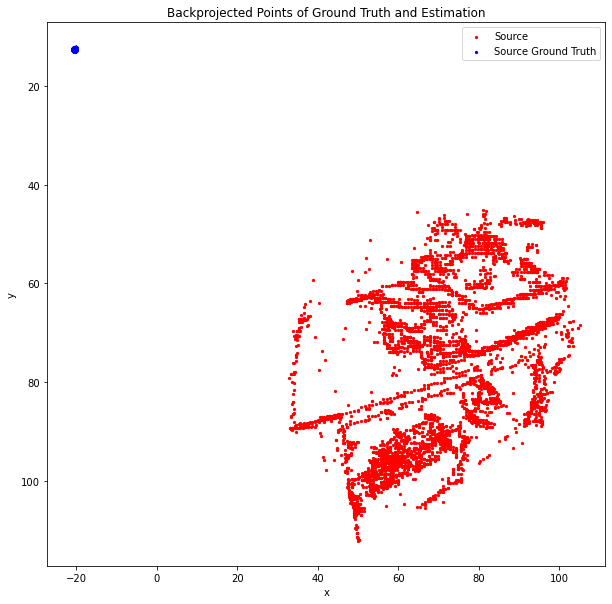

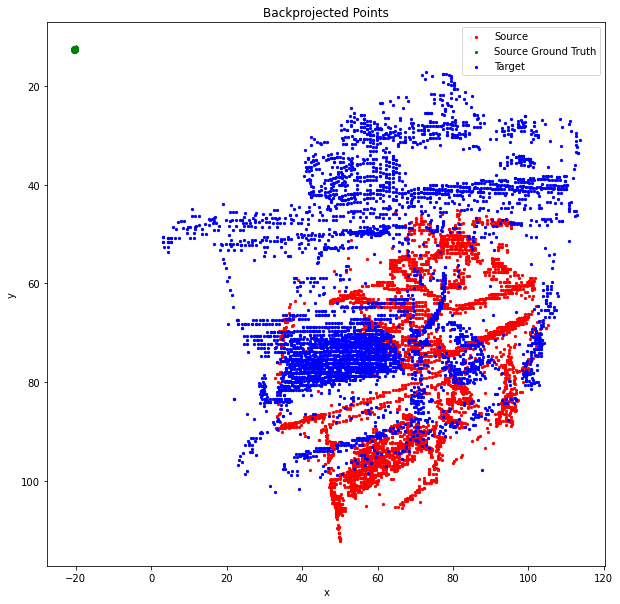

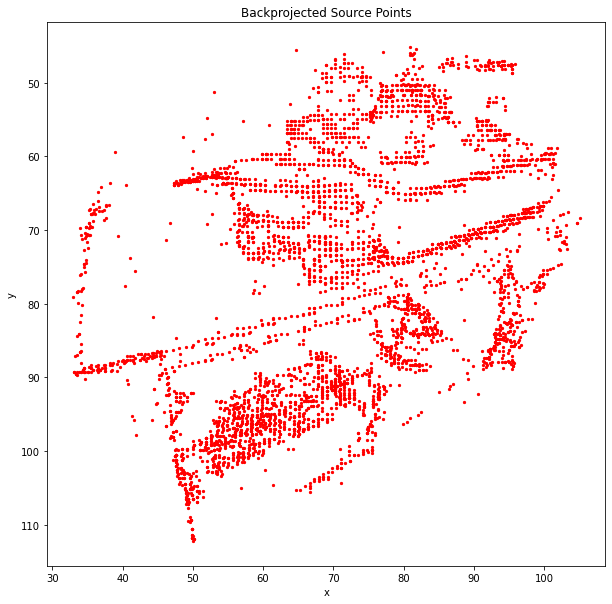

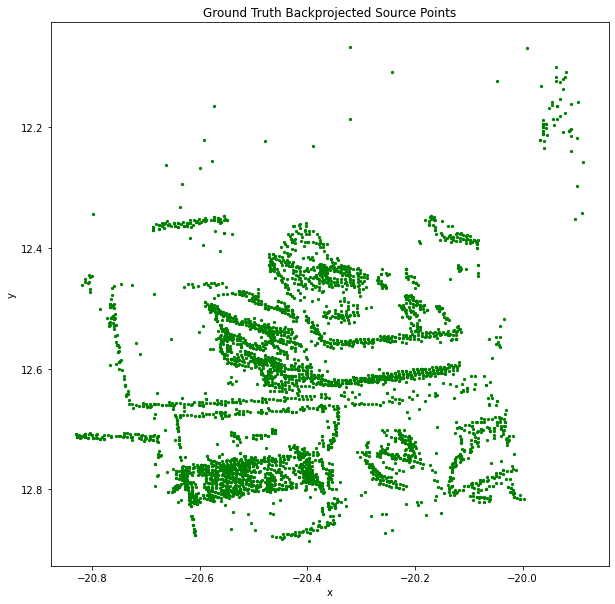

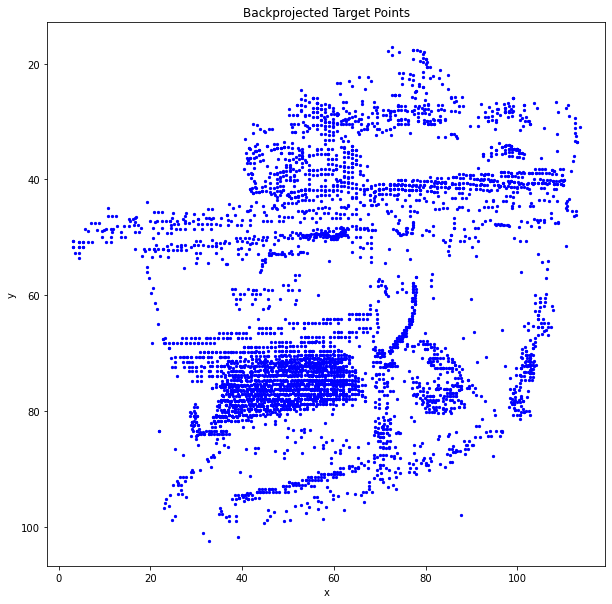

In [13]:
# Extract x and y coordinates
source_x = source_points[:, 0]
source_y = source_points[:, 1]
source_x_gt = source_points_gt[:, 0]
source_y_gt = source_points_gt[:, 1]
target_x = target_points[:, 0]
target_y = target_points[:, 1]

# Plot if the gt and estimation points backpropagation is matching 
plt.figure(figsize=(10, 10))
plt.scatter(source_x, source_y, s=5, c='red', label='Source')
plt.scatter(source_x_gt, source_y_gt, s=5, c='blue', label='Source Ground Truth')
plt.title('Backprojected Points of Ground Truth and Estimation')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.legend()
plt.show()

# Plot the points
plt.figure(figsize=(10, 10))
plt.scatter(source_x, source_y, s=5, c='red', label='Source')
plt.scatter(source_x_gt, source_y_gt, s=5, c='green', label='Source Ground Truth')
plt.scatter(target_x, target_y, s=5, c='blue', label='Target')
plt.title('Backprojected Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.legend()
plt.show()

# Plot backprojected source points
plt.figure(figsize=(10, 10))
plt.scatter(source_x, source_y, s=5, c='red')
plt.title('Backprojected Source Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.show()

# Plot Ground truth backprojected source points
plt.figure(figsize=(10, 10))
plt.scatter(source_x_gt, source_y_gt, s=5, c='green')
plt.title('Ground Truth Backprojected Source Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.show()

# Plot target points
plt.figure(figsize=(10, 10))
plt.scatter(target_x, target_y, s=5, c='blue')
plt.title('Backprojected Target Points')
plt.xlabel('x')
plt.ylabel('y')
plt.gca().invert_yaxis()  # Flip the y-axis to match image coordinates
plt.show()